In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error

2024-05-11 16:06:56.838307: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-11 16:06:56.844887: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-11 16:06:56.893108: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-11 16:06:57.776225: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
data = pd.read_csv('train.csv')
data.head()

,datetime,open,high,low,close,volume
0,2024-04-22 09:15:00,48146.30,48146.30,47859.60,47894.35,3300612.0
1,2024-04-22 09:16:00,47908.40,47919.30,47890.30,47908.35,2785305.0
2,2024-04-22 09:17:00,47898.35,47920.75,47895.05,47909.25,1431875.0
3,2024-04-22 09:18:00,47911.85,47928.25,47884.20,47893.85,1208345.0
4,2024-04-22 09:19:00,47894.60,47894.60,47824.35,47835.05,1352687.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  4500 non-null   object 
 1   open      4500 non-null   float64
 2   high      4500 non-null   float64
 3   low       4500 non-null   float64
 4   close     4500 non-null   float64
 5   volume    4500 non-null   float64
dtypes: float64(5), object(1)
memory usage: 211.1+ KB


In [4]:
data["close"]=pd.to_numeric(data.close,errors='coerce')
data = data.dropna()
trainData = data.iloc[:,4:5].values

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  4500 non-null   object 
 1   open      4500 non-null   float64
 2   high      4500 non-null   float64
 3   low       4500 non-null   float64
 4   close     4500 non-null   float64
 5   volume    4500 non-null   float64
dtypes: float64(5), object(1)
memory usage: 211.1+ KB


In [6]:
sc = MinMaxScaler(feature_range=(0,1))
trainData = sc.fit_transform(trainData)
trainData.shape

(4500, 1)

In [7]:
X_train = []
y_train = []

for i in range (60,1149): #60 : timestep // 1149 : length of the data
    X_train.append(trainData[i-60:i,0]) 
    y_train.append(trainData[i,0])

X_train,y_train = np.array(X_train),np.array(y_train)

In [8]:
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1)) #adding the batch_size axis
X_train.shape

(1089, 60, 1)

In [9]:
model = Sequential()

model.add(LSTM(units=100, return_sequences = True, input_shape =(X_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(units =1))
model.compile(optimizer='adam',loss="mean_squared_error")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
hist = model.fit(X_train, y_train, epochs = 20, batch_size = 32, verbose=5)

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


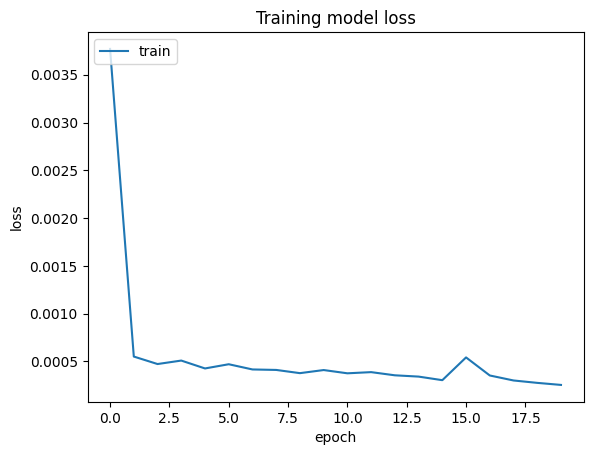

In [11]:
plt.plot(hist.history['loss'])
plt.title('Training model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [12]:
testData = pd.read_csv('test.csv')
testData["close"]=pd.to_numeric(testData.close,errors='coerce')
testData = testData.dropna()
testData = testData.iloc[:,4:5]
y_test = testData.iloc[60:,0:].values 
#input array for the model
inputClosing = testData.iloc[:,0:].values 
inputClosing_scaled = sc.transform(inputClosing)
inputClosing_scaled.shape
X_test = []
length = len(testData)
timestep = 60
for i in range(timestep,length):  
    X_test.append(inputClosing_scaled[i-timestep:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
X_test.shape

(315, 60, 1)

In [13]:
y_pred = model.predict(X_test)
y_pred

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


array([[ 0.18988414],
       [ 0.18614158],
       [ 0.18126349],
       [ 0.1755535 ],
       [ 0.16945313],
       [ 0.16334833],
       [ 0.15750091],
       [ 0.15157282],
       [ 0.1454779 ],
       [ 0.13936198],
       [ 0.13331896],
       [ 0.12717927],
       [ 0.12108816],
       [ 0.11533502],
       [ 0.11018495],
       [ 0.10578793],
       [ 0.1022585 ],
       [ 0.09980968],
       [ 0.0986374 ],
       [ 0.09873483],
       [ 0.1001184 ],
       [ 0.10266196],
       [ 0.1060667 ],
       [ 0.10974175],
       [ 0.11310166],
       [ 0.11572745],
       [ 0.117344  ],
       [ 0.11803735],
       [ 0.11788609],
       [ 0.11693696],
       [ 0.1151374 ],
       [ 0.11266797],
       [ 0.10973042],
       [ 0.10645929],
       [ 0.10310685],
       [ 0.09988059],
       [ 0.09720971],
       [ 0.09541553],
       [ 0.09463107],
       [ 0.09477963],
       [ 0.09544276],
       [ 0.09633087],
       [ 0.09728488],
       [ 0.09838219],
       [ 0.09970962],
       [ 0

In [14]:
predicted_price = sc.inverse_transform(y_pred)


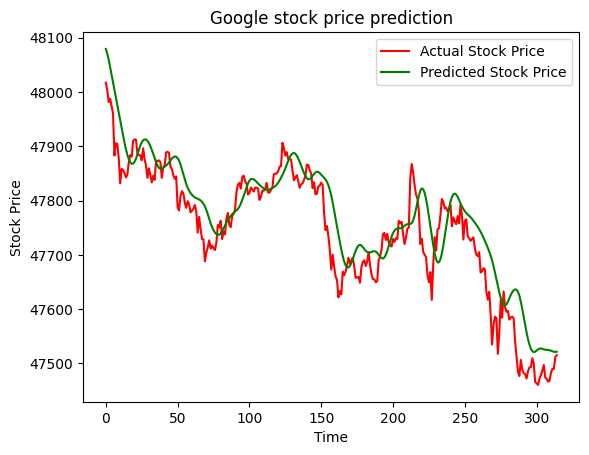

In [15]:
plt.plot(y_test, color = 'red', label = 'Actual Stock Price')
plt.plot(predicted_price, color = 'green', label = 'Predicted Stock Price')
plt.title('Google stock price prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [16]:
mse = np.mean((predicted_price - y_test) ** 2)
accuracy = 100 - mse  # Example metric, higher values indicate better accuracy

print("Mean Squared Error (MSE):", mse)
print("Accuracy:", accuracy)

Mean Squared Error (MSE): 2900.5239767795
Accuracy: -2800.5239767795
